In [1]:
import torch 
from torch import nn
import numpy as np
from score_sde import VPSDE, subVPSDE, VESDE
from score_net import ContinousTimeDenseScoreNet
from score_loss import continuous_denoised_loss, continuous_score_matching_loss

import tqdm
import sbibm 
from sbibm.metrics import c2st

import matplotlib.pyplot as plt
from sbi.analysis import pairplot


In [30]:
task = sbibm.get_task("slcp")
prior = task.get_prior_dist()
simulator = task.get_simulator()

thetas = prior.sample((10000,))
xs = simulator(thetas)

In [31]:
sde = VESDE()
scorenet = ContinousTimeDenseScoreNet(5, sde.marginal_prob, context_dim=8, nonlinearity=nn.ELU, normalization=nn.LayerNorm)

In [40]:
data = [(theta, x) for theta, x in zip(thetas,xs)]
data = torch.utils.data.DataLoader(data, shuffle=True, batch_size=1000)
optimizer = torch.optim.Adam(scorenet.parameters(), lr=1e-3)
epochs = tqdm.tqdm(range(1000))
scorenet.train()
for ep in epochs:
    for theta,x in data:
        optimizer.zero_grad()
        loss = continuous_denoised_loss(scorenet, theta, context=x, eps=1e-6)
        loss.backward()
        optimizer.step()
        epochs.set_description(f"Loss: {loss}")

Loss: 2.2606730461120605: 100%|██████████| 1000/1000 [05:36<00:00,  2.97it/s]


In [41]:
x_obs = task.get_observation(1)
scorenet.eval()
score_fn = lambda x, t: scorenet(x, t,context=x_obs.repeat(x.shape[0],1)) 
rev_sde = sde.reverse(score_fn)

In [42]:
def euler_maruyana_sample(shape, eps=1e-6):
    with torch.no_grad():
        x = sde.prior_sampling(shape)
        timesteps = torch.linspace(sde.T, eps, sde.N)
        for i in range(sde.N):
            t = timesteps[i]
            dt = -1/rev_sde.N
            z = torch.randn_like(x)
            drift, diffusion = rev_sde.sde(x, t.repeat(shape[0],1))
            x_mean = x + drift*dt 
            x = x_mean + diffusion*np.sqrt(-dt)*z
    return x

In [43]:
samples = euler_maruyana_sample((10000,5))

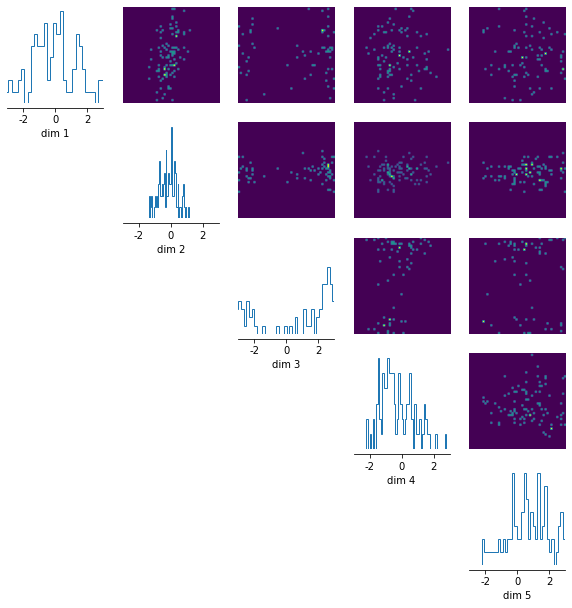

In [ ]:
_ = pairplot(samples, limits=((-3,3),(-3,3),(-3,3),(-3,3),(-3,3)))

In [37]:
ref_samples = task.get_reference_posterior_samples(1)
c2st(samples, ref_samples)

tensor([0.5828])

In [40]:
all_samples = []
for i in range(1,9):
    x_obs = task.get_observation(i)
    scorenet.eval()
    score_fn = lambda x, t: scorenet(x, t,context=x_obs.repeat(x.shape[0],1)) 
    rev_sde = sde.reverse(score_fn)
    samples = euler_maruyana_sample((10000,2))
    all_samples.append(samples)